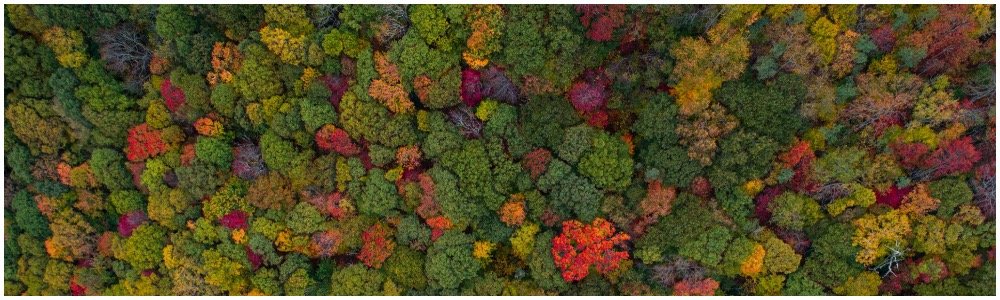

# Instructions

## Programming project: forest cover classification

In this project, you have to predict the class of forest cover (the predominant kind of tree cover) from strictly cartographic and environment variables.

The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains categorical data for qualitative independent variables (wilderness areas and soil types).

You have further details on the data at *covertype.info* file and at https://archive.ics.uci.edu/ml/datasets/Covertype

Be aware that the final dataset has been slighly modified from the original source data.

As performance metric, you can use *AUC* in the binary classification case. For multi-class classification, check as well the confussion matrix and estimate the misclassification probabilities of different classes(check *metrics.confusion_matrix* and *metrics.classification_report* in *sklearn*).

+ Using *MultiClass_Train.csv* file build a predictive model for *Cover_Type* .
+ Try a first a binary classification to predict class #7 (Krummholz, https://en.wikipedia.org/wiki/Krummholz), which is a rare valuable habitat. After that, then try multi-variate classification to predict all classes.
+ For this analysis there is an extra test dataset. Once your code is submitted we will run a competition to see how you score in the test data. Hence have prepared also the necessary script to compute the accuracy estimate on the test data once released.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Create *dummy variables* for relevant categorical features
3. Reformat the Class_type variable into a binary one, being class #7 the target variable versus the others.
4. *Build* an initial binary model for class #7 versus the other ones and test it on the same input data. 
5. Assess expected accuracy using *cross-validation*
6. Report which variable impacts more on results 
7. Try to improve it using methods to tackle class imbalance.
8. Repeat 4., 5., 6. and 7. now with a multi-class model (EXTENDED PROJECT)
9. Produce .csv for kaggle testing 


## Main criteria for grading
From more to less important (the weighting of these components will vary between the in-class and extended projects):
+ Code runs
+ Data preparation
+ Logistic Regression Models(s) have been used
+ Cover Type prediction made
+ Accuracy of predictions for test set (kaggle)
+ Class imbalance management
+ Hyperparameter optimization

# **0. Load Libraries and Data**

In [ ]:
# clear all
%reset -f

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
os.chdir('/content/drive/My Drive/CML1_Projects/Project2_LinearClassification')

Mounted at /content/drive


In [ ]:
# Load libraries
import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np

#from sklearn import metrics
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import PolynomialFeatures as plf
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict as cvp

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# Set some global options

# Set print options (show narrays as decimals, not scientific)
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

Custom functions:

In [ ]:
# Set print options (show narrays as decimals, not scientific)
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [ ]:
import schindler_project2_functions as my_fcts
dir(my_fcts)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'make_roc_plot',
 'pd',
 'plot_confusion_matrix',
 'plt',
 'reweight',
 'sns']

# **1. Exploratory Data Analysis**

NB: See also here for guide to EDA for logit: [http://www.jeremy-oakley.staff.shef.ac.uk/mas61004/EDAtutorial/eda-for-logistic-regression.html](http://www.jeremy-oakley.staff.shef.ac.uk/mas61004/EDAtutorial/eda-for-logistic-regression.html).

In [ ]:
# Read  data
df_train = pd.read_csv('Data/MultiClass_Train.csv', index_col = 0)
df_test = pd.read_csv('Data/MultiClass_Test.csv', index_col = 0)

print(df_train.columns)
print(df_test.columns)

Index(['Elevation', 'Aspect', 'Slope', 'Horiz_dist_hydro',
       'Vertical_dist_hydro', 'Horiz_dist_roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm', 'Horiz_dist_firepoints',
       'Cover_Type', 'Wilderness_Area', 'Soil_Type'],
      dtype='object')
Index(['Elevation', 'Aspect', 'Slope', 'Horiz_dist_hydro',
       'Vertical_dist_hydro', 'Horiz_dist_roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm', 'Horiz_dist_firepoints',
       'Wilderness_Area', 'Soil_Type'],
      dtype='object')


In [ ]:
# Column(s) in train but not in test dataset
df_train.columns.difference(df_test.columns)

Index(['Cover_Type'], dtype='object')

In [ ]:
# Inspect value counts of target variable
df_train['Cover_Type'].value_counts()

2    29690
1    22199
3     3802
7     2163
6     1865
5      992
4      295
Name: Cover_Type, dtype: int64

1         AxesSubplot(0.1,0.559091;0.173913x0.340909)
2    AxesSubplot(0.308696,0.559091;0.173913x0.340909)
3    AxesSubplot(0.517391,0.559091;0.173913x0.340909)
4    AxesSubplot(0.726087,0.559091;0.173913x0.340909)
5             AxesSubplot(0.1,0.15;0.173913x0.340909)
6        AxesSubplot(0.308696,0.15;0.173913x0.340909)
7        AxesSubplot(0.517391,0.15;0.173913x0.340909)
dtype: object

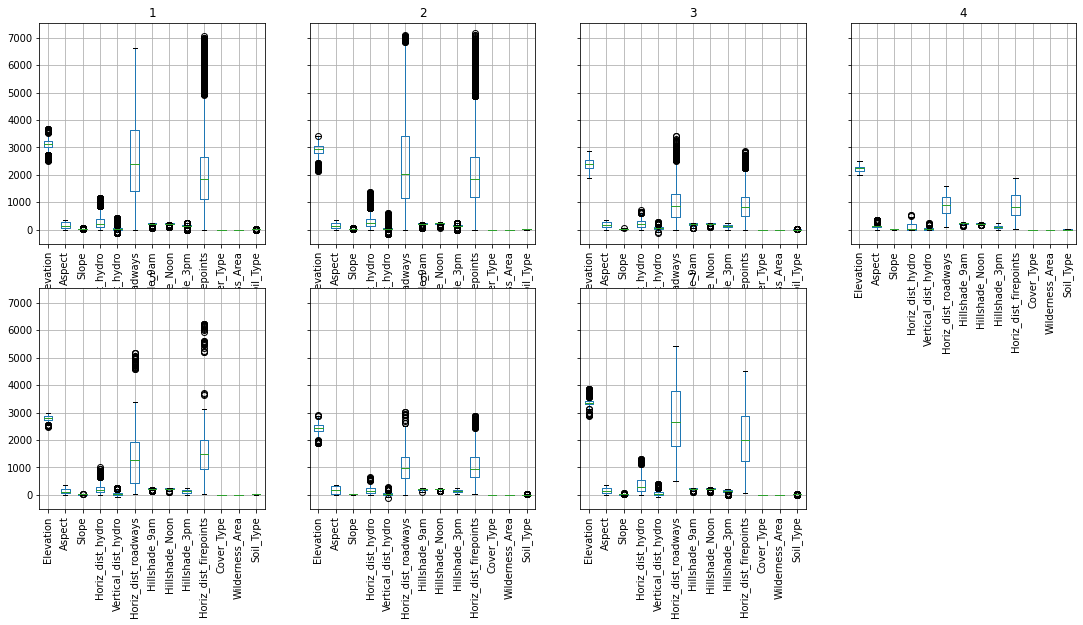

In [ ]:
# Check distribution of predictors
df_train.groupby('Cover_Type').boxplot(rot=90, figsize = [18,9], layout = (2, 4) )

There seems to be variation in the distribution of featuers for different categories of $Cover\_Type$. This is revisited again for the constructed target variable of $Cover\_Type == 7$.

In [ ]:
#Check for missing values
print(df_train.isnull().sum())
print("\n")
print(df_test.isnull().sum())

Elevation                0
Aspect                   0
Slope                    0
Horiz_dist_hydro         0
Vertical_dist_hydro      0
Horiz_dist_roadways      0
Hillshade_9am            0
Hillshade_Noon           0
Hillshade_3pm            0
Horiz_dist_firepoints    0
Cover_Type               0
Wilderness_Area          0
Soil_Type                0
dtype: int64


Elevation                0
Aspect                   0
Slope                    0
Horiz_dist_hydro         0
Vertical_dist_hydro      0
Horiz_dist_roadways      0
Hillshade_9am            0
Hillshade_Noon           0
Hillshade_3pm            0
Horiz_dist_firepoints    0
Wilderness_Area          0
Soil_Type                0
dtype: int64


# **2. Preprocessing Data**

## 2.1 Set Target Variable

Creating binary target variable for binary models. Class 7 is the target to predict. Also creating a copy for the multiclass model.

In [ ]:
# Binary target variable
target_bin = [1 if q == 7 else 0 for q in df_train['Cover_Type'] ]
print(target_bin.count(0))
print(target_bin.count(1))

58843
2163


So we seem to have class imbalance as only roughly 3.5% are class #7.

In [ ]:
# Multiclass target variable
target_multi = df_train['Cover_Type'].copy()
target_multi.value_counts()

2    29690
1    22199
3     3802
7     2163
6     1865
5      992
4      295
Name: Cover_Type, dtype: int64

In [ ]:
# Remove target from training data set
df_train = df_train.drop('Cover_Type', axis = 1)

## 2.2 Divide Continuous and Categorical Features

In [ ]:
cat_feats = ['Soil_Type', 'Wilderness_Area']

# Data sets with continuous feats
df_train_cont = df_train.drop(cat_feats, axis = 1)
df_test_cont = df_test.drop(cat_feats, axis = 1)

#Data sets with categorical feats
df_train_cat = df_train[cat_feats]
df_test_cat = df_test[cat_feats]

## 2.3 Transform Categorical Features

I simply create dummies for the categorical features $Wilderness\_Area$ and $Soil\_Type$.

In [ ]:
# Train data
df_train_dumm = pd.get_dummies(df_train_cat, prefix=['wild_area'], columns=['Wilderness_Area'], drop_first = True)
df_train_dumm = pd.get_dummies(df_train_dumm, prefix=['soil_'], columns=['Soil_Type'], drop_first = True)

# Test data
df_test_dumm = pd.get_dummies(df_test_cat, prefix=['wild_area'], columns=['Wilderness_Area'], drop_first = True)
df_test_dumm = pd.get_dummies(df_test_dumm, prefix=['soil_'], columns=['Soil_Type'], drop_first = True)

## 2.4 Transform Continuous Features

### 2.4.1 Polynomial Transformation

In [ ]:
%%capture 

# Set degree 
degree = 2

# Instantiate
poly = plf(degree, include_bias = False)

# Fit 
poly.fit(df_train_cont)

# Get column names
poly_col_names = poly.get_feature_names(df_train_cont.columns) 

# Transform data
df_train_poly = poly.transform(df_train_cont)
df_test_poly = poly.transform(df_test_cont)

# Dataframes
df_train_poly = pd.DataFrame(df_train_poly, columns = poly_col_names, index = df_train_cont.index)
df_test_poly = pd.DataFrame(df_test_poly, columns = poly_col_names, index = df_test_cont.index)

In [ ]:
df_train_poly.columns.difference(df_test_poly.columns) #No difference

Index([], dtype='object')

### 2.4.2 Standardize Continuous Features

Because regression models are run with a penalty term the data should be standardized in order for the penalty to be equivalent across features with different scales

In [ ]:
# Instantiate
scaler = StandardScaler()

# Fit
scaler.fit(df_train_poly)

# Transform
df_train_poly_scl = scaler.transform(df_train_poly)
df_test_poly_scl = scaler.transform(df_test_poly)

# Dataframes
df_train_poly_scl = pd.DataFrame(df_train_poly_scl, columns = df_train_poly.columns, index = df_train_poly.index)
df_test_poly_scl = pd.DataFrame(df_test_poly_scl, columns = df_test_poly.columns, index = df_test_poly.index)

## 2.5 Concatanate Continuous and Categorical Transformed Features

In [ ]:
df_train_for_reg = pd.concat([df_train_dumm, df_train_poly_scl], axis = 1)
df_test_for_predict = pd.concat([df_test_dumm, df_test_poly_scl], axis = 1)

# **3. Binary Logistic Model – Baseline**

## 3.1. Fit Model

In [ ]:
# To report stats
feature_names = df_train_for_reg.columns
class_labels = ['Not Krummholz', 'Krummholz']

In [ ]:
# Instantiate logistic regression
logit_base = LogisticRegression(penalty='none', 
                                C=100.0, 
                                fit_intercept=True, 
                                max_iter=5000)

# Fit
logit_base.fit(df_train_for_reg, target_bin) # Run time: 1m 3s

# Predict point estimates (for confusion matrix)
y_hat = logit_base.predict(df_train_for_reg)

# Predicted probabilities
p_hat = logit_base.predict_proba(df_train_for_reg)
p_hat = p_hat[:,1]
print(p_hat )

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


[0.42 0.00 0.00 ... 0.00 0.00 0.00]


## 3.2. Accuracy Assessment (in-sample)

In [ ]:
# AUC metric
fpr_base, tpr_base, thresholds_base = metrics.roc_curve(target_bin, p_hat)
roc_auc_base = metrics.auc(fpr_base, tpr_base)
print(roc_auc_base)

0.9859083083628767


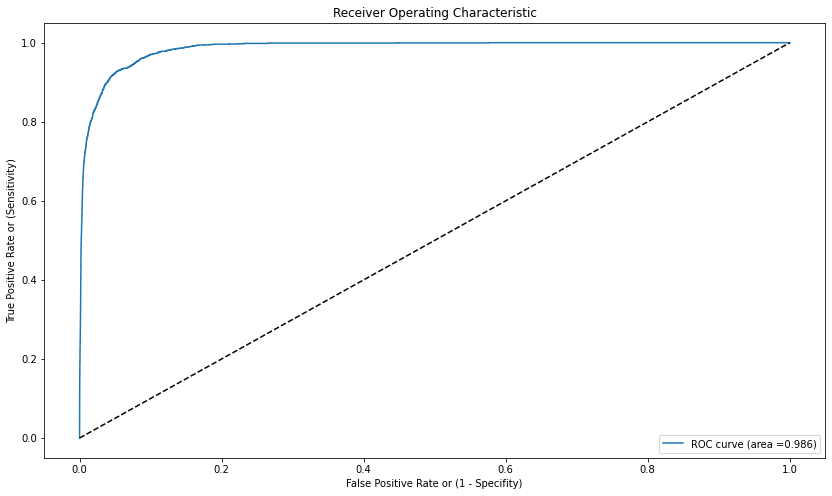

In [ ]:
my_fcts.make_roc_plot(fpr_base, tpr_base, roc_auc_base)

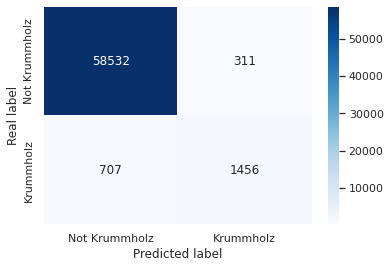

In [ ]:
# Plot confusion matrix
cm_base = confusion_matrix(y_pred=y_hat, y_true=target_bin, labels=[0,1] )

my_fcts.plot_confusion_matrix(cm_base, class_labels) 

In [ ]:
# Report feature impact
print(abs(logit_base.coef_))

[[0.19 2.20 0.58 0.20 0.19 7.13 0.02 0.10 0.07 0.11 0.02 6.02 3.34 6.59
  0.58 0.01 5.16 0.33 0.48 0.25 6.42 1.26 1.43 0.19 0.57 1.30 2.39 0.86
  3.27 1.70 1.80 1.22 1.22 1.68 1.12 1.61 1.35 11.07 1.76 2.26 1.30 50.96
  23.93 4.98 12.91 0.70 10.51 3.89 0.96 0.38 5.28 36.42 7.94 7.67 0.98
  3.94 2.18 7.04 14.03 4.80 7.74 0.63 2.37 0.11 0.17 0.05 12.17 4.71 6.86
  0.07 0.40 0.41 0.87 1.10 2.01 5.02 2.22 0.85 0.88 0.35 0.33 14.34 11.83
  9.17 0.42 0.29 0.21 4.62 5.05 3.62 0.42 2.12 9.43 4.05 6.35 5.96 12.09
  13.95 7.66 1.93 0.65 1.98 1.59 1.11 0.52 2.24]]


Note to self: See also [https://sefiks.com/2021/01/06/feature-importance-in-logistic-regression/](https://sefiks.com/2021/01/06/feature-importance-in-logistic-regression/) for one way of calculating feature importance for logistic regression.

## 3.3 Accuracy Assessment (out-of-sample)

In [ ]:
# Note to self: 'cvp' is alias for sklearn.model_selection.cross_val_predict
p_hat_cv_proba = cvp(logit_base, df_train_for_reg, target_bin, cv=5, method='predict_proba') #Runtime = 
p_hat_cv_proba = p_hat_cv_proba[:,1]
print(p_hat_cv_proba)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


KeyboardInterrupt: ignored

In [ ]:
# Cross-validated AUC metric
fpr_base_cv, tpr_base_cv, thresholds_base_cv = metrics.roc_curve(target_bin, p_hat_cv_proba)
roc_auc_base_cv = metrics.auc(fpr_base_cv, tpr_base_cv)
print(roc_auc_base_cv)

In [ ]:
my_fcts.make_roc_plot(fpr_base_cv, tpr_base_cv, roc_auc_base_cv)

In [ ]:
# Plot confusion matrix
y_hat_cv_proba = cvp(logit_base, df_train_for_reg, target_bin, cv=10) 

cm_base_cv = confusion_matrix(y_pred=y_hat_cv_proba, y_true=target_bin, labels=[0,1] )

my_fcts.plot_confusion_matrix(cm_base_cv, class_labels) 

# **4. Hyperparameter Optimization**

# **5. Binary Logistic Model – Oversampled**

## 5.0 Oversample Data

I have also tried undersampling, and with various ways of preprocessing. This is my preferred model. 

In [ ]:
ros = RandomOverSampler(random_state=0)
F_resampled, y_resampled = ros.fit_resample(df_train_for_reg, target_bin)

## 5.1 Fit Model

In [ ]:
#Instantiate logistic regression on resampled data
                                #C=100 
logit_opt = LogisticRegression(C=0.2682695795279725, 
                               class_weight='balanced',
                               penalty='l2', 
                               solver='liblinear')

# Fit
logit_opt.fit(F_resampled,y_resampled) #Run time: 6s

# Predict classes
p_hat_opt = logit_opt.predict(df_train_for_reg)

#Predicted probabilities
p_hat_opt_proba = logit_opt.predict_proba(df_train_for_reg)
p_hat_opt_proba = p_hat_opt_proba[:,1]
print(p_hat_opt_proba)

[0.96 0.01 0.00 ... 0.00 0.00 0.00]


In [ ]:
# Set correct weights for correction function
target_bin = np.array(target_bin)
y_resampled = np.array(y_resampled)

# Ratio of 1s in original target
q1 = target_bin.sum()/len(target_bin)

# Ratio of 1s in resampled target
r1 = y_resampled.sum()/len(y_resampled)

In [ ]:
# correcting ''imb'' predictions for biased sample
p_hat_opt_proba = pd.Series(p_hat_opt_proba)
p_hat_opt_proba_corr = p_hat_opt_proba.apply(my_fcts.reweight,args=(q1,r1))
p_hat_opt_proba_corr

0        4.756160e-01
1        4.701916e-04
2        1.135284e-06
3        4.489570e-04
4        8.633912e-05
             ...     
61001    3.681027e-01
61002    9.420457e-04
61003    6.422468e-05
61004    6.976492e-09
61005    2.280602e-07
Length: 61006, dtype: float64

## 5.2 Accuracy Assessment (in-sample)

In [ ]:
# AUC metric
fpr_opt, tpr_opt, thresholds_opt = metrics.roc_curve(target_bin, p_hat_opt_proba_corr)
roc_auc_opt = metrics.auc(fpr_opt, tpr_opt)
print(roc_auc_opt)

0.9855661188074626


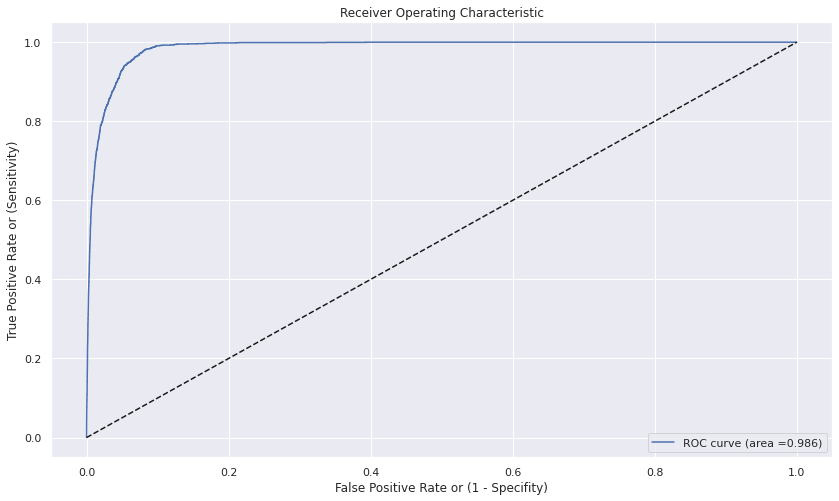

In [ ]:
my_fcts.make_roc_plot(fpr_opt, tpr_opt, roc_auc_opt)

## 5.3 Accuracy Assessment (out-of-sample)

# **6. Multiclass Logictic Model**

## 6.1 Set Correct Datasets for Multiclass Predictions

In [ ]:
# To report stats
feature_names = df_train_for_reg.columns
class_labels_multi = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']

In [ ]:
target_multi.value_counts()

2    29690
1    22199
3     3802
7     2163
6     1865
5      992
4      295
Name: Cover_Type, dtype: int64

## 6.2 Fit Multiclass Model

In [ ]:
#Instantiate logistic regression
logit_multi = LogisticRegression(penalty='l2', C=100.0, 
                           fit_intercept=True, 
                           multi_class = 'multinomial',
                           solver= 'lbfgs', 
                           max_iter=1000)

#Fit
logit_multi.fit(df_train_for_reg,target_multi) # Run time: 1m 23s

#Predicted classes
p_hat_multi = logit_multi.predict(df_train_for_reg)
p_hat_multi = pd.DataFrame(p_hat_multi)
p_hat_multi

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


,0
0,1
1,1
2,2
3,1
4,1
...,...
61001,1
61002,2
61003,2
61004,3


## 6.3 Accuracy Assessment

In [ ]:
print(target_multi.value_counts())

p_hat_multi_df = pd.DataFrame(p_hat_multi)
print(p_hat_multi_df.value_counts())

2    29690
1    22199
3     3802
7     2163
6     1865
5      992
4      295
Name: Cover_Type, dtype: int64
2    31435
1    21742
3     4324
7     1789
6     1301
4      229
5      186
dtype: int64


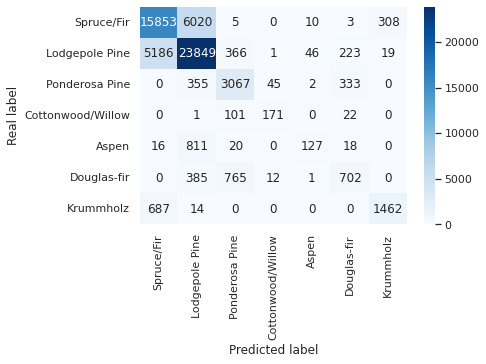

In [ ]:
# Confusion Matrix 
cm_multi =  confusion_matrix(y_pred=p_hat_multi, 
                             y_true=target_multi, 
                             labels=[1,2,3,4,5,6,7])
my_fcts.plot_confusion_matrix(cm_multi, class_labels_multi)

In [ ]:
# Classification Report
print(classification_report(y_true = target_multi, y_pred = p_hat_multi))

              precision    recall  f1-score   support

           1       0.73      0.71      0.72     22199
           2       0.76      0.80      0.78     29690
           3       0.71      0.81      0.75      3802
           4       0.75      0.58      0.65       295
           5       0.68      0.13      0.22       992
           6       0.54      0.38      0.44      1865
           7       0.82      0.68      0.74      2163

    accuracy                           0.74     61006
   macro avg       0.71      0.58      0.62     61006
weighted avg       0.74      0.74      0.74     61006



# _Export Binary Predictions for Kaggle Competition

In [ ]:
# Dataframe for submission w. imb. predictions
p_hat_test_kaggle = logit_opt.predict_proba(df_test_for_predict)
p_hat_test_kaggle = p_hat_test_kaggle[:,1]

kaggle = pd.DataFrame(p_hat_test_kaggle, index = df_test_for_predict.index).rename(columns={0: "p_hat_test_kaggle"})


# Reweight dataframe w. imb. predictions
q1 = target_bin.sum()/len(target_bin)
r1 = y_resampled.sum()/len(y_resampled)

kaggle["p_hat_test_kaggle"] = kaggle["p_hat_test_kaggle"].apply(my_fcts.reweight,args=(q1,r1))
kaggle

,p_hat_test_kaggle
Index,
61006,1.550401e-03
61007,9.732540e-06
61008,4.852134e-01
61009,1.532558e-09
61010,1.455151e-05
...,...
74074,6.188404e-05
74075,1.562746e-05
74076,1.180626e-06


In [ ]:
# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"Index": kaggle.index, "Cover_Type": kaggle['p_hat_test_kaggle']})
test_predictions_submit.to_csv("Predictions/pred9_cleaned-notebook.csv", index = False)

# _Export Multiclass Predictions for Kaggle Competition

In [ ]:
# Dataframe for submission in multiclass competition
p_hat_multi_test_kaggle = logit_multi.predict(df_test_for_predict)

kaggle_multi = pd.DataFrame(p_hat_multi_test_kaggle, index = df_test_for_predict.index).rename(columns={0: "p_hat_multi_test_kaggle"})
kaggle_multi 

,p_hat_multi_test_kaggle
Index,
61006,1
61007,2
61008,7
61009,6
61010,2
...,...
74074,1
74075,2
74076,2


In [ ]:
test_multiclass_predictions_submit = pd.DataFrame({"Index": kaggle_multi.index, "Cover_Type": kaggle_multi['p_hat_multi_test_kaggle']})
test_multiclass_predictions_submit.to_csv("Predictions/Multi/pred2_poly2.csv", index = False)